# 分析を進めていくとわかってきたこと
前節のデータは、３ヶ月間の総授業回数（`M`）と出席回数（`Y`）だった。  
解析を進めると、さらに新事実が伺えてきた
- 授業日の天気が出席確率に影響

本説では、集計前のデータを使って回帰を行う。集計前データは2396回の出欠を記録している。
- `Weather`：天気（A:はれ B:曇り C:雨)
- `Y`：授業への出席状態の二値（１：出席、０；欠席）
その他、5.2と同じ。同じ学生（`PersonID`）でも、複数の授業に登録し、出席するため`PersonID`の重複はいくらでもあることに注意。

# 解析の目的
- ３つの説明変数（A, Score, Weather）でYをどれほど予測できるか？
- 説明変数はどれほど出席確率に影響しているか？→ ロジスティック回帰を実施


In [3]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# 描画
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
import seaborn as sns
import arviz as az
# plt.rcParams['font.family'] = 'Meiryo'

import sklearn
from sklearn.metrics import roc_curve, roc_auc_score

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

print(f"{pm.__version__=}")
print(f"{sklearn.__version__=}")

pm.__version__='5.16.2'
sklearn.__version__='1.5.1'


In [5]:
### データの読み込み ◆データファイル5.3 data-attendance-3.txtの構成
# PersonID:学生ID、A:バイト好き区分(1:好き), Weather:天気（A:晴れ、B:曇り、C:雨）
# Y:出欠区分：授業に出席したかどうか（0:欠席、1:出席）

data = pd.read_csv('./input/data-attendance-3.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (2396, 5)


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [6]:
data.pivot_table(index="Weather", columns="Y", values="PersonID", 
                 aggfunc="count")

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [8]:
### 天気の重み係数を設定 ◆テキスト71ページに記述の変換処理
Weather_dict2 = {'A': 0, 'B': 0.2, 'C': 1}
data['Weather_w'] = data['Weather'].map(Weather_dict2)
data.head()

,PersonID,A,Score,Weather,Y,Weather_w
0,1,0,69,B,1,0.2
1,1,0,69,A,1,0.0
2,1,0,69,C,1,1.0
3,1,0,69,A,1,0.0
4,1,0,69,B,1,0.2


↑天気が晴れ（A）の時は、出席率が高そう。  
A, B, C = 0, 0.2, 1　とする(<u>曇りの影響：雨の影響＝１：５とする措置</u>)

**このように背景知識を家庭としてモデリングすることが大切**

# モデリング
- 出席確率 $q = invlogit(b_1 + b_2A + b_3Score + b_4Weather)$
- $Y \sim Bernoulli(q)$
- 学生ごとではなく、出欠ごと、になっている

In [19]:
with pm.Model() as model:
    model.add_coord("data", values=data.index, mutable=True)
    model.add_coord("beta", values=[1, 2, 3, 4], mutable=True)

    Y = pm.ConstantData("Y", value=data["Y"].values, dims="data")
    A = pm.ConstantData("A", value=data["A"].values, dims="data")
    Score = pm.ConstantData("Score", value=data["Score"].values / 200, dims="data")
    W = pm.ConstantData("W", value=data["Weather_w"].values, dims="data")

    b = pm.Uniform("b", lower=-10, upper=10, dims="beta")

    q = pm.Deterministic("q", pm.invlogit(b[0] + b[1] + b[2]*Score + b[3]*W), dims="data")

    obs = pm.Bernoulli("obs", p=q, observed=Y, dims="data")

### モデルの表示
model

  b ~ Uniform(-10, 10)
  q ~ Deterministic(f(b))
obs ~ Bernoulli(q)

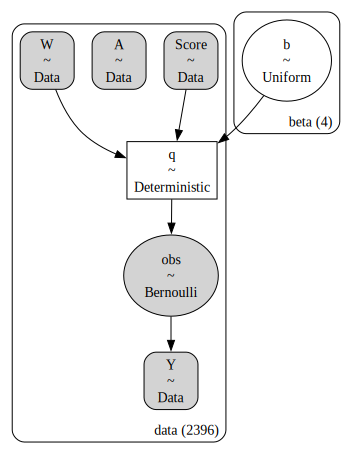

In [20]:
g = pm.model_to_graphviz(model)
display(g)

In [21]:
### 事後分布からのサンプリング 25秒 ◆run-model5-5.R
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                      nuts_sampler='numpyro', random_seed=1234)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 0:  10%|█         | 200/2000 [00:02<00:14, 121.19it/s]





Running chain 0:  15%|█▌        | 300/2000 [00:06<00:36, 46.93it/s] 


Running chain 0:  20%|██        | 400/2000 [00:10<00:46, 34.53it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:13<00:42, 35.58it/s]


Running chain 0:  30%|███       | 600/2000 [00:14<00:32, 43.51it/s]



Running chain 0:  35%|███▌      | 700/2000 [00:16<00:29, 43.50it/s]




Running chain 0:  40%|████      | 800/2000 [00:19<00:26, 44.96it/s]


Running chain 0:  50%|█████     | 1000/2000 [00:25<00:26, 37.66it/s]


Running chain 0:  55%|█████▌    | 1100/2000 [00:28<00:25, 35.02it/s]


Running chain 0:  60%|██████    | 1200/2000 [00:32<00:25, 31.38it/s]

Running chain 0:  70%|███████   | 1400/2000 [00:40<00:21, 27.88it/s]


Running chain 0:  75%|███████▌  | 1500/2000 [00:44<00:18, 27.66it/s]


Running chain 0:  85%|███

In [22]:
### r_hat>1.1の確認
# 設定
idata_in = idata         # idata名
threshold = 1.01         # しきい値

# しきい値を超えるR_hatの個数を表示
print((az.rhat(idata_in) > threshold).sum())


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    b        int64 8B 0
    q        int64 8B 0


In [23]:
### 推論データの要約統計情報の表示
var_names = ['b', 'q']
pm.summary(idata, hdi_prob=0.95, var_names=var_names, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[1],0.115,5.607,-8.711,9.825,0.177,0.127,840.317,697.205,1.005
b[2],-0.206,5.607,-9.935,8.563,0.177,0.126,838.808,704.626,1.005
b[3],1.881,0.362,1.194,2.621,0.010,0.007,1405.238,1543.903,1.001
b[4],-0.461,0.125,-0.689,-0.213,0.003,0.002,1697.292,1791.061,1.002
q[0],0.614,0.024,0.567,0.660,0.001,0.000,1608.879,2267.522,1.001
...,...,...,...,...,...,...,...,...,...
q[2391],0.679,0.013,0.654,0.703,0.000,0.000,2318.137,2579.984,1.000
q[2392],0.698,0.014,0.672,0.725,0.000,0.000,2258.817,2689.239,1.001
q[2393],0.698,0.014,0.672,0.725,0.000,0.000,2258.817,2689.239,1.001
q[2394],0.593,0.027,0.543,0.646,0.001,0.000,1728.130,2177.727,1.001


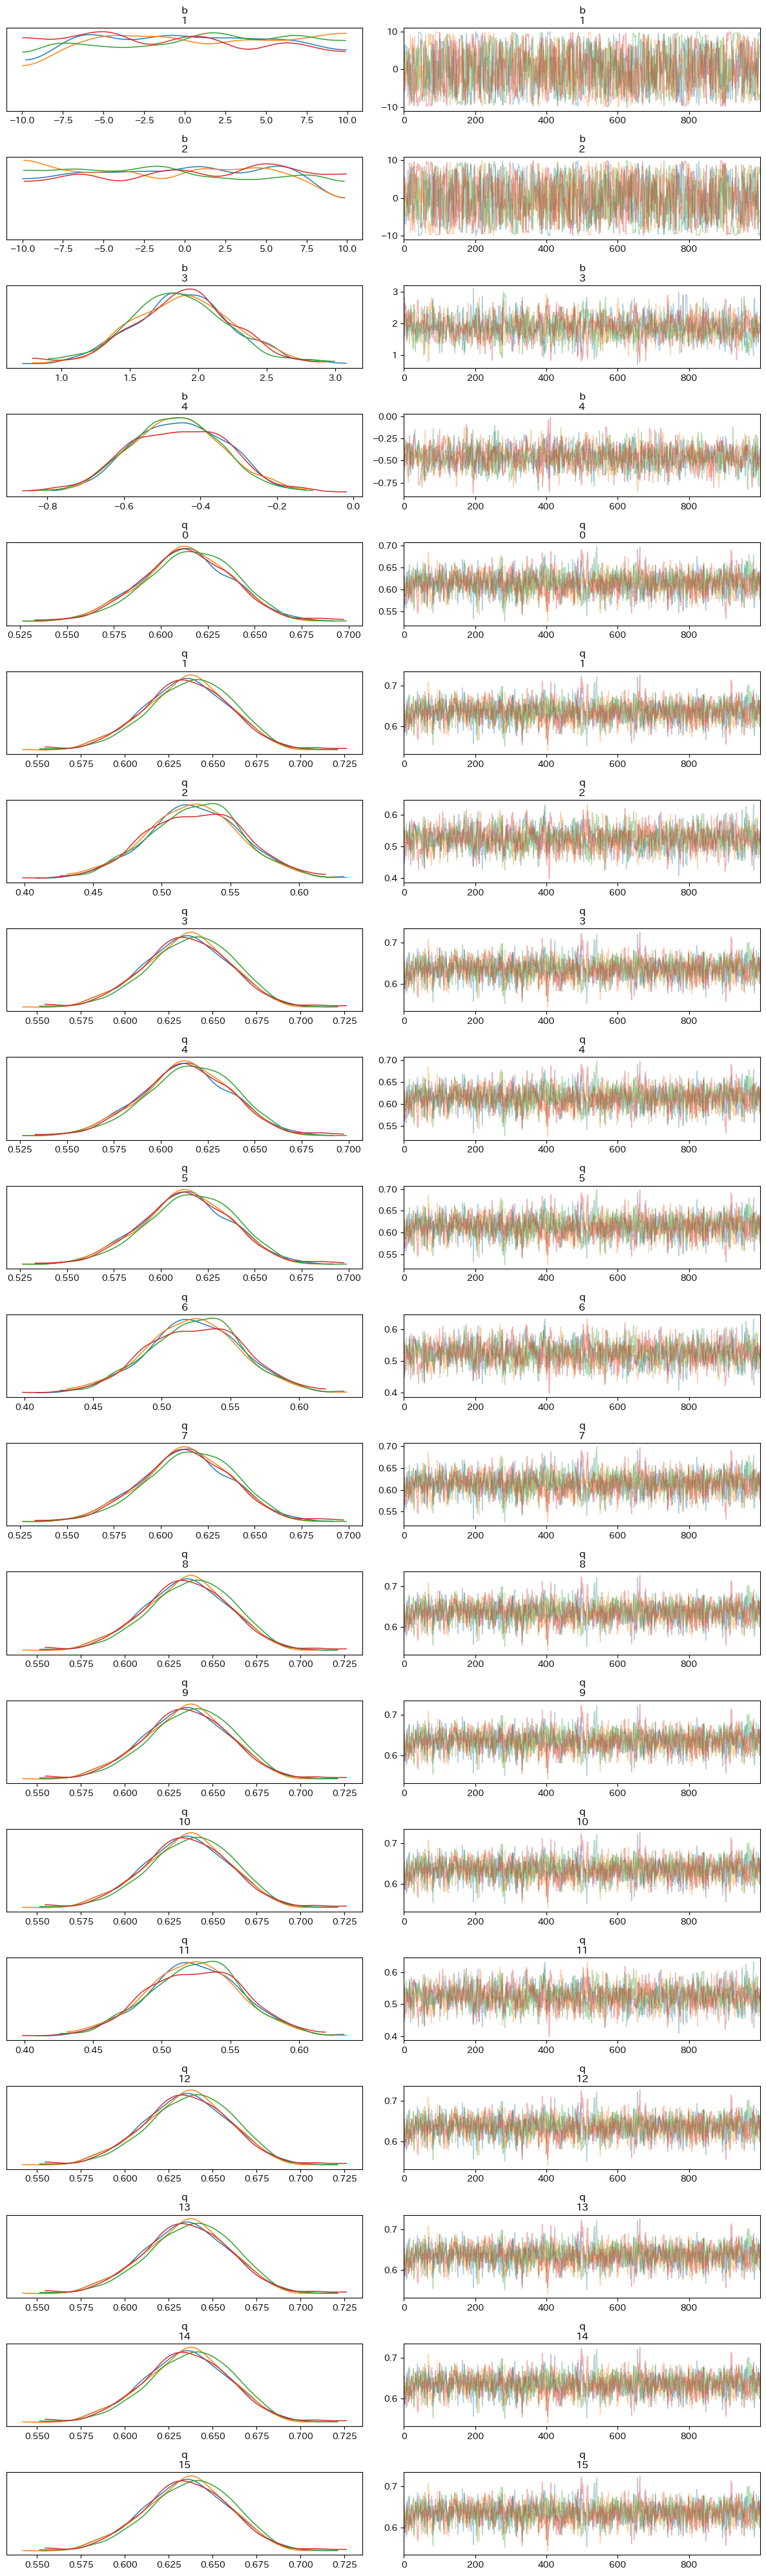

In [24]:
### トレースプロットの表示
pm.plot_trace(idata, compact=False, var_names=var_names)
plt.tight_layout();

In [25]:
### Yの事後予測分布のサンプリング
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=1234))

Sampling: [obs]


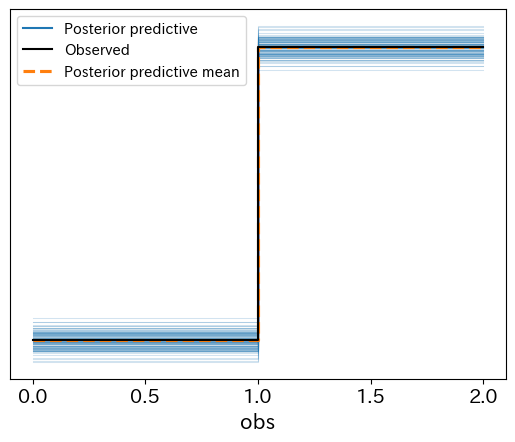

In [17]:
### ppcプロットの描画
pm.plot_ppc(idata, num_pp_samples=100);

In [26]:
### パラメータの要約を確認

## 統計量算出関数：mean,sd,2.5%,25%,50%,75%,97.5%点をデータフレーム化する
def make_stats_df(y):
    probs = [2.5, 25, 50, 75, 97.5]
    columns = ['mean', 'sd'] + [str(s) + '%' for s in probs]
    quantiles = pd.DataFrame(np.percentile(y, probs, axis=0).T, index=y.columns)
    tmp_df = pd.concat([y.mean(axis=0), y.std(axis=0), quantiles], axis=1)
    tmp_df.columns=columns
    return tmp_df

## 要約統計量の算出・表示
# 事後分布サンプリングデータidataからパラメータbを取り出してデータフレーム化
param_samples = pd.DataFrame(
    idata.posterior.b.stack(sample=('chain', 'draw')).T.data,
    columns=['b1', 'b2', 'b3', 'b4'])
# 上記データフレームを統計量算出関数に与えて事後統計量データフレームを作成
params_stats_df = make_stats_df(param_samples)
# 事後統計量データフレームの表示
display(params_stats_df.round(2))

,mean,sd,2.5%,25%,50%,75%,97.5%
b1,0.11,5.61,-9.22,-4.80,0.07,5.00,9.47
b2,-0.21,5.61,-9.52,-5.08,-0.14,4.70,9.09
b3,1.88,0.36,1.16,1.64,1.88,2.11,2.60
b4,-0.46,0.12,-0.70,-0.55,-0.46,-0.37,-0.22
